# Packages

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

from lmfit import Model

import scipy.special
import math

from astropy.io import fits

import random

from astropy.time import Time

import os

from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clip

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

plt.rc('font', family='serif', size=11)
plt.tight_layout()

<Figure size 900x600 with 0 Axes>

In [11]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

# Functions

In [12]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

def vrad2(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio  * 1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) + sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1/term2*term3
    
    return sol






#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

In [13]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [14]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

In [15]:
def get_phase(t, y, nu):
    """Some black magic to calculate the phase for a given
    segment of data for set frequencies

    Parameters
    ----------
    nu : array-like
        Frequencies for which the phase will be calculated
    t : array-like
        Time-stamps
    y : array-like
        Flux values corresponding to `t`

    Returns
    -------
    phases
        Given phases for each frequency.
    """
    
    t = np.array(t)
    y = np.array(y)
    nu = np.array(nu)
    
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan(w[:len(nu)] / w[len(nu):2*len(nu)])

In [16]:
#Fourier Function
def fourier_sum(freqs, amps, phase, y_noise, x):
    y = []
    for j in range(0, len(x)):
        temp = []
        temp.append(y_noise[j])
        for i in range(0, len(freqs)):
            #next line: sum(amplitude_i * sine(freq_i * x + phase_i)) for all pulsations i 
            temp.append(amps[i]*np.sin(2.*np.pi*freqs[i]*x[j]+phase[i]))
        y.append(sum(temp))
    return y

def lc_sim(freqs, amps, phs, time_start, time_end, cadence, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time = np.arange(time_start, time_end, cadence)
    noise = np.random.normal(0, precision, len(time))
    
    multisine = np.array(fourier_sum(freqs, amps, phs, noise, time))

    return [freqs, amps, phs, time, multisine]

def lc_model(freqs, amps, phs, time_start, time_end, cadence_model):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = np.arange(time_start, time_end, cadence_model)
    noise_model = [0 for i in time_model]    

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = np.random.normal(0, precision, len(time_model))
    #noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

In [67]:
def jd_to_datetime(jd, returniso=False):

    tt = Time(jd, format='jd', scale='utc')

    if returniso:
        return tt.iso
    else:
        return tt.datetime 

In [68]:
jd_to_datetime(2457097)

datetime.datetime(2015, 3, 15, 12, 0)

In [353]:
#https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
def fit_leastsq_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
    
        def fit_leastsq(p0, datax, datay, function):

            errfunc = lambda p, x, y: function(x,p) - y

            pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

            if (len(datay) > len(p0)) and pcov is not None:
                s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
                pcov = pcov * s_sq
            else:
                pcov = np.inf

            error = [] 
            for i in range(len(pfit)):
                try:
                    error.append(np.absolute(pcov[i][i])**0.5)
                except:
                    error.append( 0.00 )
            pfit_leastsq = pfit
            perr_leastsq = np.array(error) 
            return pfit_leastsq, perr_leastsq 

        pfit, perr = fit_leastsq(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

# Extract data

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


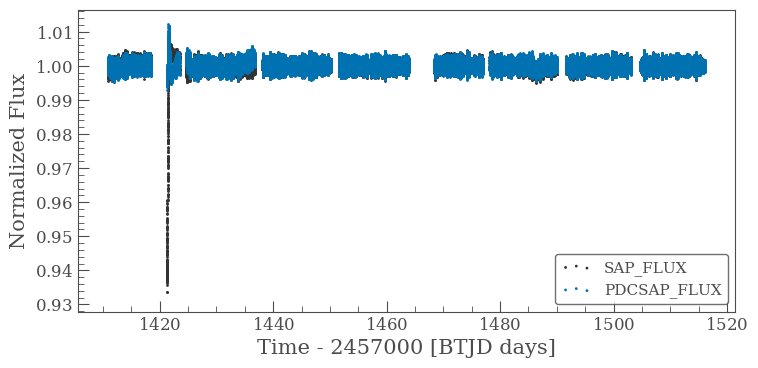

In [22]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)

In [69]:
jds = []
for i in np.arange(2015, 2023, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2015-01-01T12:00:00.000']
[2457024.]
['2016-01-01T12:00:00.000']
[2457389.]
['2017-01-01T12:00:00.000']
[2457755.]
['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]
['2021-01-01T12:00:00.000']
[2459216.]
['2022-01-01T12:00:00.000']
[2459581.]


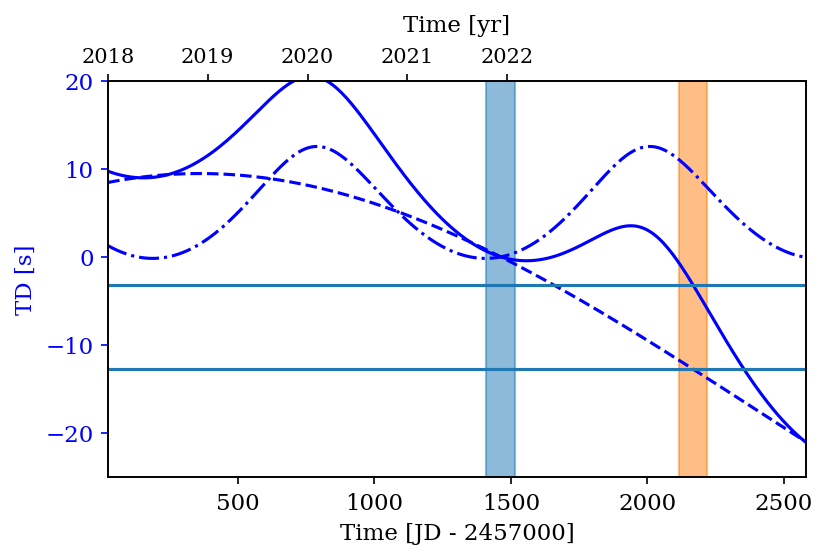

In [70]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)

TESS_mm_tmid = min(times) + (max(times) - min(times))/2

y_tau_b_offset = tau(TESS_mm_tmid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_offset = tau(TESS_mm_tmid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

time_offset = 2457000

fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))


ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns11 = ax1.plot(t_18_22 - time_offset, (y_tau_b + y_tau_c-y_tau_b_offset-y_tau_c_offset) * 86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(t_18_22 - time_offset, (y_tau_b-y_tau_b_offset) * 86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(t_18_22 - time_offset, (y_tau_c-y_tau_c_offset) * 86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")


lns31 = ax1.axvspan(min(times) - time_offset, max(times) - time_offset, alpha=0.5,  label='TESS (mm)', color='C0')
lns32 = ax1.axvspan(min(times)+704 - time_offset, max(times)+704 - time_offset, alpha=0.5,  label='TESS (em)', color='C1')

ax1.set_xlabel('Time [JD - 2457000]')
ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-25,20)


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset
t_2022 = jds[4] - time_offset


ax2.set_xticks([t_2018,t_2019,t_2020,t_2021,t_2022])


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2018', '2019', '2020', '2021', '2022'], fontsize=10)
ax2.set_xlabel('Time [yr]')
ax2.xaxis.set_label_coords(0.5,1.125)

ax1.axhline((tau(TESS_mm_tmid+704, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)
ax1.axhline((tau(TESS_mm_tmid+704, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)-y_tau_c_offset+tau(TESS_mm_tmid+704, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)

In [25]:
freq, amp = AS(times, mags, 200)

freq=freq[5000:]
amp=amp[5000:]

max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.1, distance=200)

sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

45


In [28]:
freq, amp = AS(tTESS, mTESS, 200)

freq=freq[5000:]
amp=amp[5000:]

max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.1, distance=200)

sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

38


(47.42889037014255, 47.44889037014254)

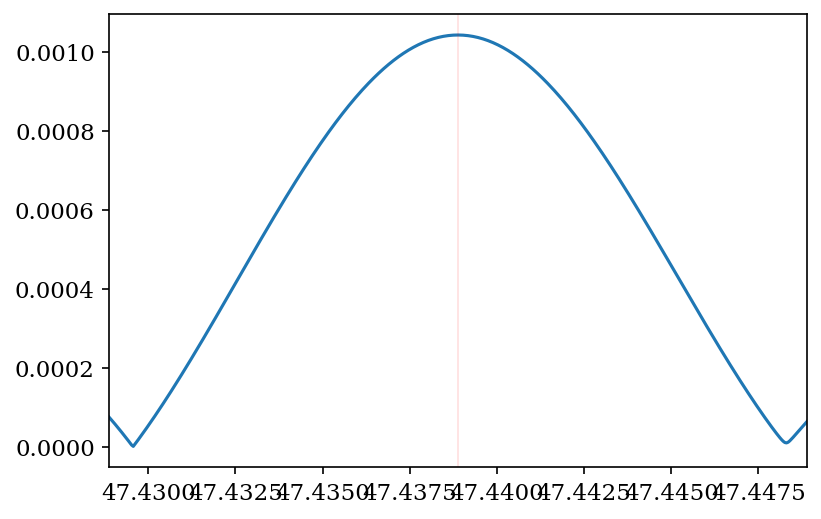

In [29]:
plt.plot(freq, amp, ls='-')
plt.axvline(f_TESS[0], c='r', lw=0.1)
plt.xlim(f_TESS[0]-0.01, f_TESS[0]+0.01)

In [30]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

# Real 

In [27]:
import os
datadir = os.getcwd() + '/data/'


tTESS, mTESS = np.loadtxt(datadir + 'TESS.txt').T
tB15, mB15 = np.loadtxt(datadir + 'BRITE15.txt').T
tB16, mB16 = np.loadtxt(datadir + 'BRITE16.txt').T
tB17, mB17 = np.loadtxt(datadir + 'BRITE17.txt').T
tA17, mA17 = np.loadtxt(datadir + 'ASTEP17_2048.txt').T
tA18, mA18 = np.loadtxt(datadir + 'ASTEP18_2048.txt').T
tR1, mR1 = np.loadtxt(datadir + 'bRing1.txt').T
tR2, mR2 = np.loadtxt(datadir + 'bRing2.txt').T

In [31]:
mid = min(tB15) + (max(tTESS) - min(tB15))/2

In [32]:
mid

2457807.0382811422

In [66]:
tB15

array([2457097.98961235, 2457097.98978935, 2457097.98996735, ...,
       2457176.31247614, 2457176.31259514, 2457176.31283414])

In [33]:
tAT = np.concatenate((tA17, tA18, tTESS))
mAT = np.concatenate((mA17, mA18, mTESS))

tRT = np.concatenate((tR1, tR2, tTESS))
mRT = np.concatenate((mR1, mR2, mTESS))

tBT = np.concatenate((tB15, tB16, tB17, tTESS))
mBT = np.concatenate((mB15, mB16, mB17, mTESS))

In [34]:
#f_TESS_tmp=f_TESS

In [35]:
#f_TESS=np.array([47.4388713874922,50.4918274156299,53.6918502054937,54.2377124619654])

In [36]:
x=tTESS
y=mTESS

In [37]:
#peaks=f_TESS[:4]

In [38]:
# def chi2(nu):
#     arg = 2*np.pi*nu[None, :]*x[:, None]
#     D = np.concatenate([np.cos(arg), np.sin(arg),
#                 np.ones((len(x), 1))],
#                 axis=1)

#     # Solve for the amplitudes and phases of the oscillations
#     DTD = np.matmul(D.T, D)
#     DTy = np.matmul(D.T, y[:, None])
#     w = np.linalg.solve(DTD, DTy)
#     model = np.squeeze(np.matmul(D, w))

#     chi2_val = np.sum(np.square(y - model))
#     return chi2_val

# res = optimize.minimize(chi2, [peaks], method="L-BFGS-B")
# print(res.x)

In [39]:
#f_TESS = res.x

In [216]:
f_TESS = [47.43903, 53.69192, 50.49180, 54.23763]
a_TESS = [1.042, 0.968, 0.934, 0.562]
f_TESS = np.array(f_TESS)
a_TESS = np.array(a_TESS)/1000

In [211]:
f_TESS = TESS_f
f_TESS = np.array(f_TESS)

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
44235
1
111813
2
165075
3
229684
[array([5.168322  , 0.84594272, 0.58991625, 2.26057906]), array([5.80781024, 3.99878208, 0.81837016, 1.6465467 ]), array([5.85872447, 2.88050145, 1.10762193, 1.17173916]), array([5.63473586, 2.10525654, 1.18043771, 0.79525943])]
[5.168322   5.80781024 5.85872447 5.63473586]
[0.84594272 3.99878208 2.88050145 2.10525654]
[0.58991625 0.81837016 1.10762193 1.18043771]
[2.26057906 1.6465467  1.17173916 0.79525943]
[[ 2.35506335  2.99455159  3.04546582  2.82147721]
 [ 1.17427672  1.18552343  0.0672428  -0.70800211]
 [-2.2233424  -1.99488849 -1.70563672 -1.63282094]
 [-0.55267959 -1.16671195 -1.64151949 -2.01799922]]
Calc TD
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


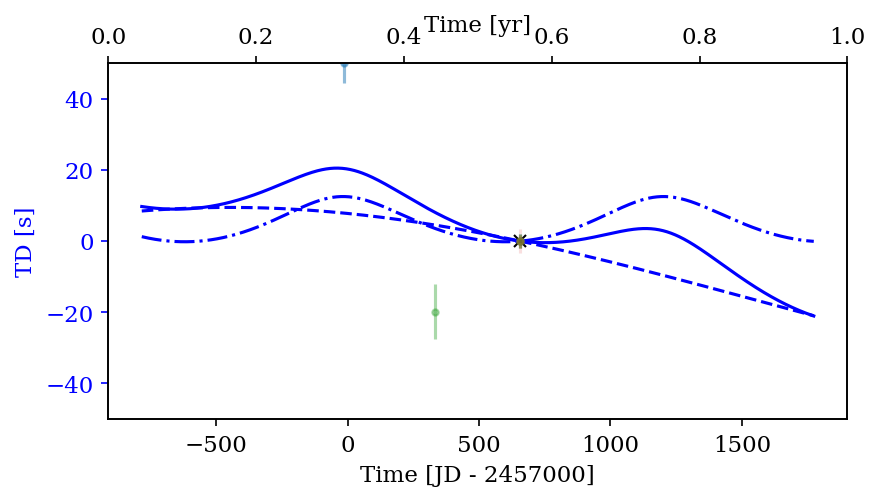

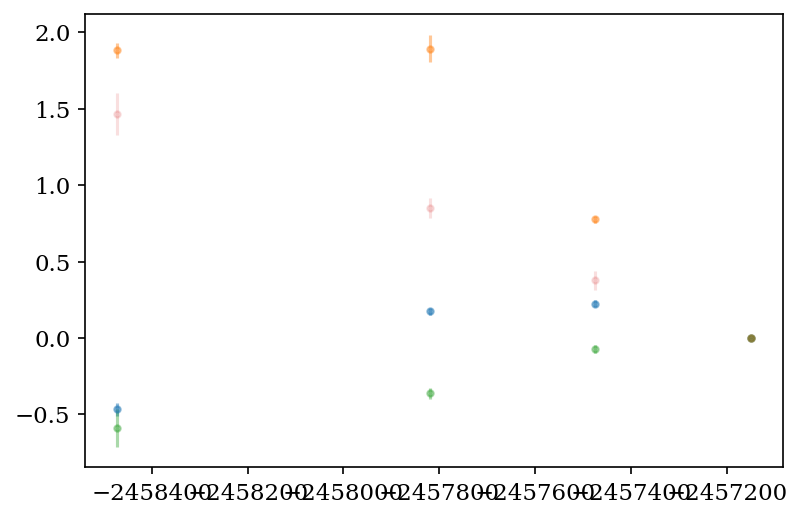

In [230]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


# times_run = tAT
# magnitudes_run = mAT
# segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

times_run = tBT-mid
magnitudes_run = mBT
segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        #print(phase)
        
print(phase)
        
phase = np.array(phase)

ph1 = [phase[iii][0] for iii in range(4)]
ph2 = [phase[iii][1] for iii in range(4)]
ph3 = [phase[iii][2] for iii in range(4)]
ph4 = [phase[iii][3] for iii in range(4)]

ph1 = np.array(ph1)
ph2 = np.array(ph2)
ph3 = np.array(ph3)
ph4 = np.array(ph4)

print(ph1)
print(ph2)
print(ph3)
print(ph4)

# for iii in range(4):
#     ph1 = [phase[iii][0] for iii in range(4)]
#     print(ph1)

mean_phase1 = np.mean(ph1)
mean_phase2 = np.mean(ph2)
mean_phase3 = np.mean(ph3)
mean_phase4 = np.mean(ph4)

ph1[np.where(ph1 - mean_phase1 > np.pi/2)] -= np.pi
ph1[np.where(ph1 - mean_phase1 < -np.pi/2)] += np.pi

ph2[np.where(ph2 - mean_phase2 > np.pi/2)] -= np.pi
ph2[np.where(ph2 - mean_phase2 < -np.pi/2)] += np.pi

ph3[np.where(ph3 - mean_phase3 > np.pi/2)] -= np.pi
ph3[np.where(ph3 - mean_phase3 < -np.pi/2)] += np.pi

ph4[np.where(ph4 - mean_phase4 > np.pi/2)] -= np.pi
ph4[np.where(ph4 - mean_phase4 < -np.pi/2)] += np.pi


phase = [ph1, ph2, ph3, ph4]
phase = np.array(phase)

#phase = np.unwrap(phase)
phase -= np.mean(phase)
#phase = np.array(phase).T
phase_err = np.array(phase_err).T

print(phase)

# mean_phase = np.mean(phase)
# phase[np.where(phase - mean_phase > np.pi/2)] -= np.pi
# phase[np.where(phase - mean_phase < -np.pi/2)] += np.pi

#print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = mid

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints), (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints), (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    leg_errbar.append(lns3)
    ax1.set_ylim(-50, 50)+mid



lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_BT = np.array(time_midpoints)
tau_td_BT = []
for j in range(len(f_TESS)):
    tau_td_BT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][-1]))
tau_td_BT = np.array(tau_td_BT)*86400
tau_err_td_BT = np.array(time_delays_err)*86400
tau_weighted_td_BT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_BT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
21009
[array([6.07423962, 3.50973262, 1.21068564, 1.58599814])]
1
42020
[array([6.07423962, 3.50973262, 1.21068564, 1.58599814]), array([5.97784265, 2.99938903, 1.2046185 , 1.46582863])]
2
106629
[array([6.07423962, 3.50973262, 1.21068564, 1.58599814]), array([5.97784265, 2.99938903, 1.2046185 , 1.46582863]), array([5.63473586, 2.10525654, 1.18043771, 0.79525943])]
[array([6.07423962, 3.50973262, 1.21068564, 1.58599814]), array([5.97784265, 2.99938903, 1.2046185 , 1.46582863]), array([5.63473586, 2.10525654, 1.18043771, 0.79525943])]
[6.07423962 5.97784265 5.63473586]
[3.50973262 2.99938903 2.10525654]
[1.21068564 1.2046185  1.18043771]
[1.58599814 1.46582863 0.79525943]
[[ 3.26223759  3.16584062  2.82273383]
 [ 0.69773059  0.187387   -0.70674549]
 [-1.60131639 -1.60738353 -1.63156432]
 [-1.22600389 -1.3461734  -2.0167426 ]]
Calc TD
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


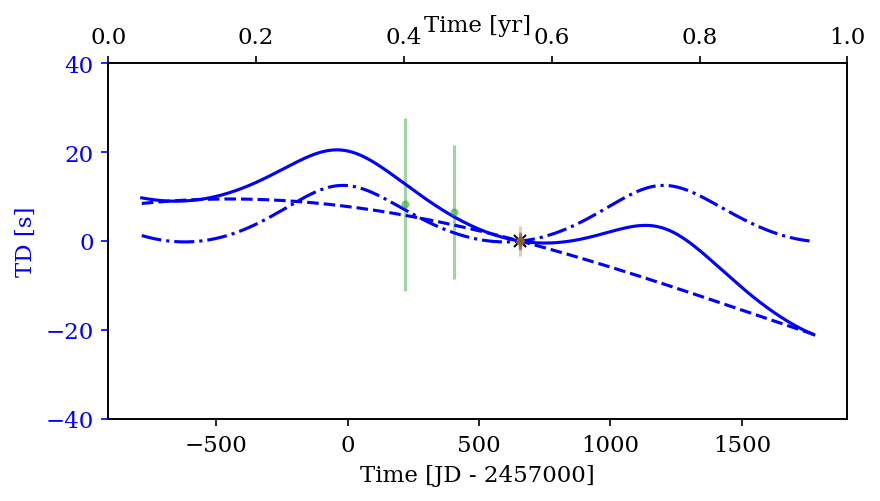

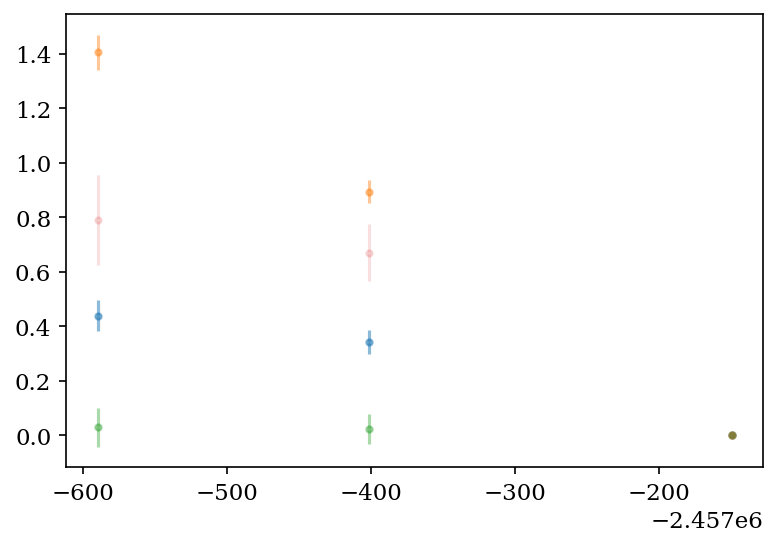

In [231]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


# times_run = tAT
# magnitudes_run = mAT
# segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

times_run = tRT- mid
magnitudes_run = mRT
segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

# times_run = tBT
# magnitudes_run = mBT
# segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        print(phase)
        

print(phase)
        
phase = np.array(phase)

ph1 = [phase[iii][0] for iii in range(3)]
ph2 = [phase[iii][1] for iii in range(3)]
ph3 = [phase[iii][2] for iii in range(3)]
ph4 = [phase[iii][3] for iii in range(3)]

ph1 = np.array(ph1)
ph2 = np.array(ph2)
ph3 = np.array(ph3)
ph4 = np.array(ph4)

print(ph1)
print(ph2)
print(ph3)
print(ph4)

# for iii in range(4):
#     ph1 = [phase[iii][0] for iii in range(4)]
#     print(ph1)

mean_phase1 = np.mean(ph1)
mean_phase2 = np.mean(ph2)
mean_phase3 = np.mean(ph3)
mean_phase4 = np.mean(ph4)

ph1[np.where(ph1 - mean_phase1 > np.pi/2)] -= np.pi
ph1[np.where(ph1 - mean_phase1 < -np.pi/2)] += np.pi

ph2[np.where(ph2 - mean_phase2 > np.pi/2)] -= np.pi
ph2[np.where(ph2 - mean_phase2 < -np.pi/2)] += np.pi

ph3[np.where(ph3 - mean_phase3 > np.pi/2)] -= np.pi
ph3[np.where(ph3 - mean_phase3 < -np.pi/2)] += np.pi

ph4[np.where(ph4 - mean_phase4 > np.pi/2)] -= np.pi
ph4[np.where(ph4 - mean_phase4 < -np.pi/2)] += np.pi

phase = [ph1, ph2, ph3, ph4]
phase = np.array(phase)

#phase = np.unwrap(phase)
phase -= np.mean(phase)
#phase = np.array(phase).T
phase_err = np.array(phase_err).T        


# mean_phase = np.mean(phase)
# phase[np.where(phase - mean_phase > np.pi/2)] -= np.pi
# phase[np.where(phase - mean_phase < -np.pi/2)] += np.pi

print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = mid

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints), (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints), (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0]))/2)
    leg_errbar.append(lns3)
    ax1.set_ylim(-40,40)



lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_RT = np.array(time_midpoints)
tau_td_RT = []
for j in range(len(f_TESS)):
    tau_td_RT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][-1]))
tau_td_RT = np.array(tau_td_RT)*86400
tau_err_td_RT = np.array(time_delays_err)*86400
tau_weighted_td_RT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_RT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
31920
[array([5.82903525, 3.70637042, 0.98902579, 1.67859239])]
1
64018
[array([5.82903525, 3.70637042, 0.98902579, 1.67859239]), array([5.78306637, 2.55167091, 1.10590467, 1.00017745])]
2
128627
[array([5.82903525, 3.70637042, 0.98902579, 1.67859239]), array([5.78306637, 2.55167091, 1.10590467, 1.00017745]), array([5.63473586, 2.10525654, 1.18043771, 0.79525943])]
[array([5.82903525, 3.70637042, 0.98902579, 1.67859239]), array([5.78306637, 2.55167091, 1.10590467, 1.00017745]), array([5.63473586, 2.10525654, 1.18043771, 0.79525943])]
[5.82903525 5.78306637 5.63473586]
[3.70637042 2.55167091 2.10525654]
[0.98902579 1.10590467 1.18043771]
[1.67859239 1.00017745 0.79525943]
[[ 3.13240752  3.08643864  2.93810812]
 [ 1.00974269 -0.14495682 -0.59137119]
 [-1.70760194 -1.59072307 -1.51619002]
 [-1.01803534 -1.69645029 -1.9013683 ]]
Calc TD
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


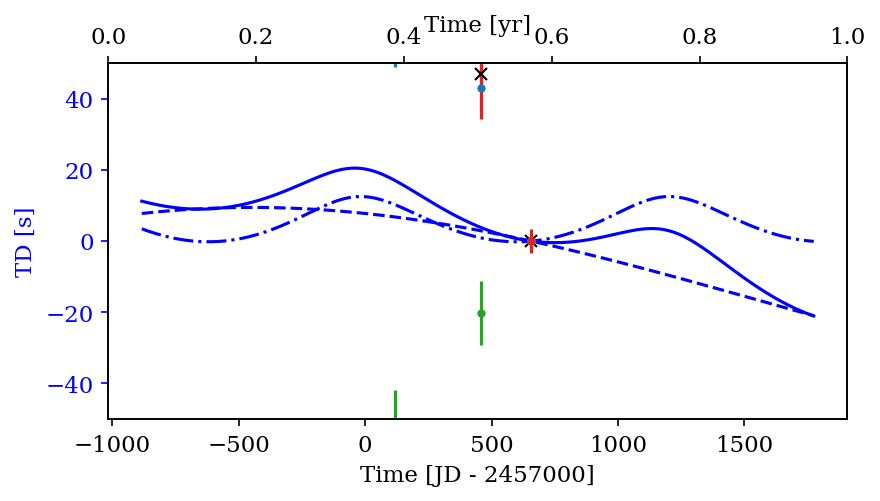

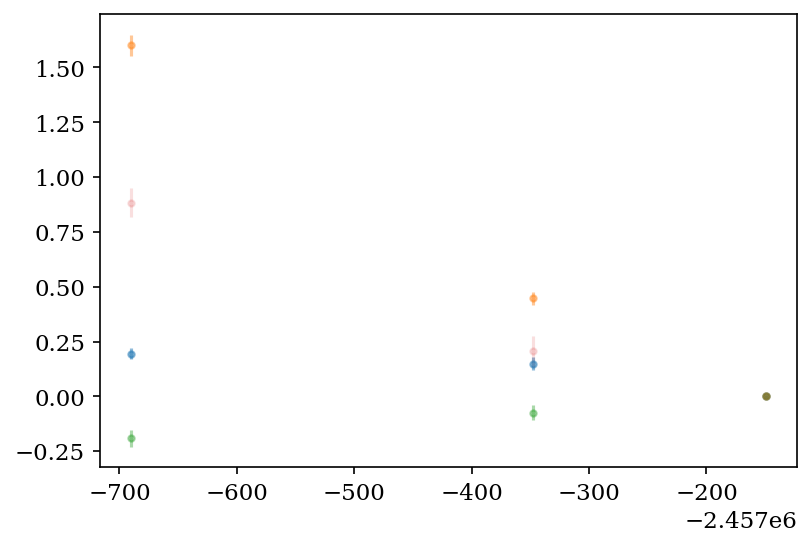

In [232]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


times_run = tAT-mid
magnitudes_run = mAT
segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

# times_run = tBT
# magnitudes_run = mBT
# segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        print(phase)
        

print(phase)
        
phase = np.array(phase)

ph1 = [phase[iii][0] for iii in range(3)]
ph2 = [phase[iii][1] for iii in range(3)]
ph3 = [phase[iii][2] for iii in range(3)]
ph4 = [phase[iii][3] for iii in range(3)]

ph1 = np.array(ph1)
ph2 = np.array(ph2)
ph3 = np.array(ph3)
ph4 = np.array(ph4)

print(ph1)
print(ph2)
print(ph3)
print(ph4)

# for iii in range(4):
#     ph1 = [phase[iii][0] for iii in range(4)]
#     print(ph1)

mean_phase1 = np.mean(ph1)
mean_phase2 = np.mean(ph2)
mean_phase3 = np.mean(ph3)
mean_phase4 = np.mean(ph4)

ph1[np.where(ph1 - mean_phase1 > np.pi/2)] -= np.pi
ph1[np.where(ph1 - mean_phase1 < -np.pi/2)] += np.pi

ph2[np.where(ph2 - mean_phase2 > np.pi/2)] -= np.pi
ph2[np.where(ph2 - mean_phase2 < -np.pi/2)] += np.pi

ph3[np.where(ph3 - mean_phase3 > np.pi/2)] -= np.pi
ph3[np.where(ph3 - mean_phase3 < -np.pi/2)] += np.pi

ph4[np.where(ph4 - mean_phase4 > np.pi/2)] -= np.pi
ph4[np.where(ph4 - mean_phase4 < -np.pi/2)] += np.pi

phase = [ph1, ph2, ph3, ph4]
phase = np.array(phase)

#phase = np.unwrap(phase)
phase -= np.mean(phase)
#phase = np.array(phase).T
phase_err = np.array(phase_err).T        


print(phase)

# mean_phase = np.mean(phase)
# phase[np.where(phase - mean_phase > np.pi/2)] -= np.pi
# phase[np.where(phase - mean_phase < -np.pi/2)] += np.pi

#print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0]-100, jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = mid

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints), (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints), (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.')#, alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    leg_errbar.append(lns3)

ax1.set_ylim(-50, 50)


lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]3
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_AT = np.array(time_midpoints)
tau_td_AT = []
for j in range(len(f_TESS)):
    tau_td_AT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][-1]))
tau_td_AT = np.array(tau_td_AT)*86400
tau_err_td_AT = np.array(time_delays_err)*86400
tau_weighted_td_AT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_AT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

In [221]:
jdss = []
for i in np.arange(2015, 2021, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jdss.append(t.jd[0])

['2015-01-01T12:00:00.000']
[2457024.]
['2016-01-01T12:00:00.000']
[2457389.]
['2017-01-01T12:00:00.000']
[2457755.]
['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]


In [224]:
import matplotlib

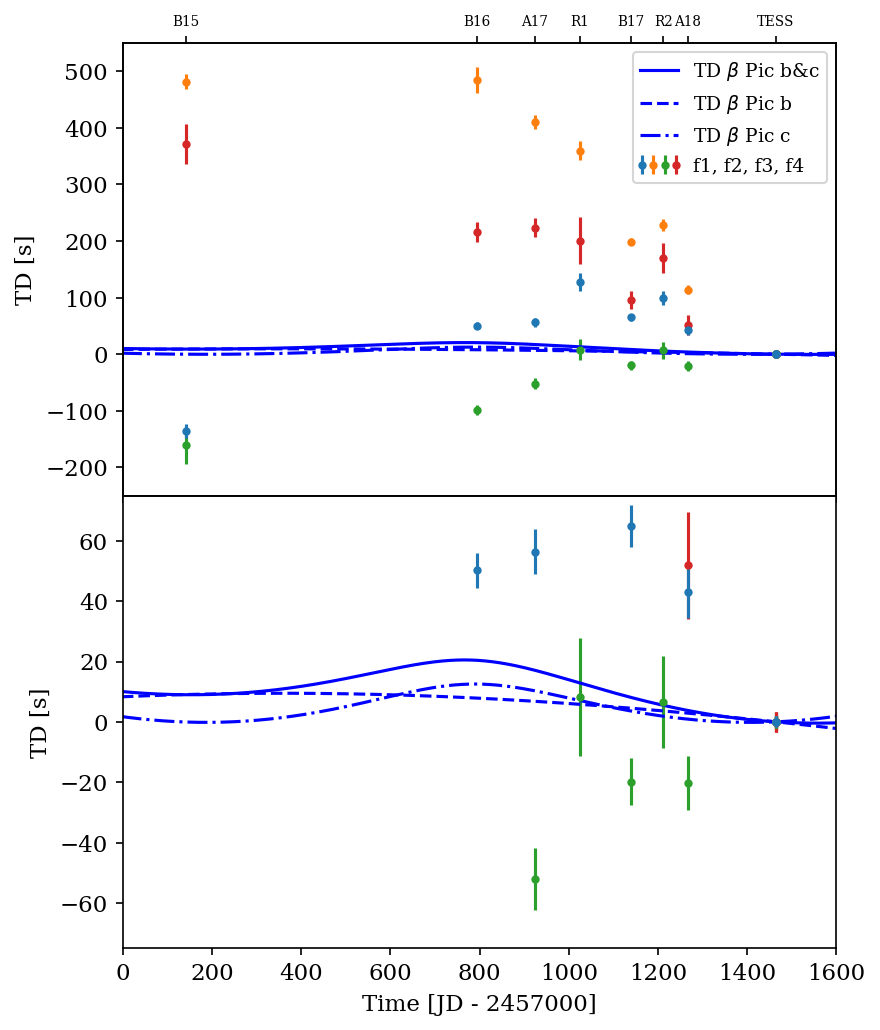

In [233]:
offf = 2457000

fig, ax1 = plt.subplots(2,1, figsize=(6, 7), sharex=True, gridspec_kw={'hspace': 0})

for i in range(4)[::-1]:
    ax1[0].errorbar(t_td_BT+mid-offf, tau_td_BT[i],yerr=tau_err_td_BT[i], c='C{0}'.format(i), fmt='.')
    ax1[0].errorbar(t_td_AT+mid-offf, tau_td_AT[i],yerr=tau_err_td_AT[i], c='C{0}'.format(i), fmt='.')
    ax1[0].errorbar(t_td_RT+mid-offf, tau_td_RT[i],yerr=tau_err_td_RT[i], c='C{0}'.format(i), fmt='.')

ax1[0].plot(times_sim-offf, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
ax1[0].plot(times_sim-offf, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
ax1[0].plot(times_sim-offf, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

ax1[0].set_xlim(jdss[0]-offf-24, jdss[-1]-250-offf)
ax1[0].set_ylim(-250,550)

ax1[0].legend(prop={'size': 8})



ax1[0].set_xlabel('Time [JD - 2457000]')
ax1[0].set_ylabel('TD [s]')
#ax1.tick_params('y', colors='b')
#ax1.set_ylim(-25,20)


ax2 = ax1[0].twiny()
ax2.tick_params(axis='x', rotation=0)

ax2.set_xticks([np.mean(tB15)-offf,np.mean(tB16)-offf,np.mean(tB17)-offf,np.mean(tA17)-offf,np.mean(tA18)-offf,np.mean(tR1)-offf,np.mean(tR2)-offf,np.mean(tTESS)-offf])

xmin1, xmax1 = ax1[0].get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['B15', 'B16', 'B17', 'A17', 'A18', 'R1', 'R2', 'TESS'], fontsize=6.5)
#ax2.set_xlabel('Time [yr]')
#ax2.xaxis.set_label_coords(0.5,1.125)

# ax3 = ax1.twiny()
# ax3.tick_params(axis='x', rotation=0, pad=5)

# ax3.set_xticks([jdss[0]-offf, jdss[1]-offf, jdss[2]-offf, jdss[3]-offf, jdss[4]-offf])

# ax3.tick_params('both', length=15, width=1, which='major')

# xmin1, xmax1 = ax1.get_xlim()
# ax3.set_xlim(xmin1,xmax1)
# ax3.set_xticklabels(['2015', '2016'], fontsize=6.5)
# ax3.set_xlabel('Time [yr]')
# ax3.xaxis.set_label_coords(0.5,1.2)

#https://stackoverflow.com/questions/52038171/how-to-create-two-legend-objects-for-a-single-plot-instance/52040748#52040748
ax1[0].legend(handles = lns[:3]+[tuple(leg_errbar[:4])], labels=labs[:3]+['f1, f2, f3, f4'],loc=0,prop={'size': 9},
              handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})




for i in range(4)[::-1]:
    ax1[1].errorbar(t_td_BT+mid-offf, tau_td_BT[i],yerr=tau_err_td_BT[i], c='C{0}'.format(i), fmt='.')
    ax1[1].errorbar(t_td_AT+mid-offf, tau_td_AT[i],yerr=tau_err_td_AT[i], c='C{0}'.format(i), fmt='.')
    ax1[1].errorbar(t_td_RT+mid-offf, tau_td_RT[i],yerr=tau_err_td_RT[i], c='C{0}'.format(i), fmt='.')

ax1[1].plot(times_sim-offf, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
ax1[1].plot(times_sim-offf, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
ax1[1].plot(times_sim-offf, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

ax1[1].set_xlim(jdss[0]-offf-24, jdss[-1]-250-offf)
ax1[1].set_ylim(-75,75)


ax1[1].set_xlabel('Time [JD - 2457000]')
ax1[1].set_ylabel('TD [s]')

plt.tight_layout()

#plt.savefig('final1.png', dpi=500)
#plt.savefig('final1.pdf')

In [ ]:
tTESS, mTESS = np.loadtxt(datadir + 'TESS.txt').T
tB15, mB15 = np.loadtxt(datadir + 'BRITE15.txt').T
tB16, mB16 = np.loadtxt(datadir + 'BRITE16.txt').T
tB17, mB17 = np.loadtxt(datadir + 'BRITE17.txt').T
tA17, mA17 = np.loadtxt(datadir + 'ASTEP17_2048.txt').T
tA18, mA18 = np.loadtxt(datadir + 'ASTEP18_2048.txt').T
tR1, mR1 = np.loadtxt(datadir + 'bRing1.txt').T
tR2, mR2 = np.loadtxt(datadir + 'bRing2.txt').T

# Recreation

In [220]:
# Freqs
# Amps
# Ph

In [521]:
multi = 1.5

resT = 0.000624325904*multi
resB15 = 0.00822189421*multi
resB16 = 0.00529456898*multi
resB17 = 0.00465416046*multi
resA1 = 0.00376961612*multi
resA2 = 0.00393032297*multi
resR1 = 0.00702802937*multi
resR2 = 0.00601361301*multi

In [522]:
def f_err_MO(times, mags, ampl):
    N = len(mags)
    timebase = max(times) - min(times)
    sigma_m = 0.00198#np.sqrt(np.mean((mags-np.mean(mags))**2))
    tmp = np.sqrt(6/N) * (1/(np.pi*timebase)) * sigma_m/ampl
    return tmp

def a_err_MO(mags):
    N = len(mags)
    sigma_m = np.std(mags)
    tmp = np.sqrt(2/N) * sigma_m
    return tmp

def p_err_MO(mags, ampl):
    N = len(mags)
    sigma_m = np.std(mags)
    tmp = np.sqrt(2/N) * sigma_m/ampl
    return tmp

In [523]:
import os 
datadir2 = os.getcwd()

TESS = np.loadtxt(datadir2 + '/mid/solT.per', usecols=(1,2,3))
B15 = np.loadtxt(datadir2 + '/mid/solB15.per', usecols=(1,2,3))
B16 = np.loadtxt(datadir2 + '/mid/solB16.per', usecols=(1,2,3))
B17 = np.loadtxt(datadir2 + '/mid/solB17.per', usecols=(1,2,3))
A1 = np.loadtxt(datadir2 + '/mid/solA1.per', usecols=(1,2,3))
A2 = np.loadtxt(datadir2 + '/mid/solA2.per', usecols=(1,2,3))
R1 = np.loadtxt(datadir2 + '/mid/solR1.per', usecols=(1,2,3))
R2 = np.loadtxt(datadir2 + '/mid/solR2.per', usecols=(1,2,3))

TESSe = np.loadtxt(datadir2 + '/mid/errT.err', usecols=(1,2,3), skiprows=21)
B15e = np.loadtxt(datadir2 + '/mid/errB15.err', usecols=(1,2,3), skiprows=21)
B16e = np.loadtxt(datadir2 + '/mid/errB16.err', usecols=(1,2,3), skiprows=21)
B17e = np.loadtxt(datadir2 + '/mid/errB17.err', usecols=(1,2,3), skiprows=21)
A1e = np.loadtxt(datadir2 + '/mid/errA1.err', usecols=(1,2,3), skiprows=21)
A2e = np.loadtxt(datadir2 + '/mid/errA2.err', usecols=(1,2,3), skiprows=21)
R1e = np.loadtxt(datadir2 + '/mid/errR1.err', usecols=(1,2,3), skiprows=21)
R2e = np.loadtxt(datadir2 + '/mid/errR2.err', usecols=(1,2,3), skiprows=21)

In [486]:
TESS_f = np.array([TESS[i][0] for i in range(4)])
TESS_a = np.array([TESS[i][1] for i in range(4)])
TESS_p = np.array([TESS[i][2] for i in range(4)])
model_T = lc_model_times(TESS_f, TESS_a, TESS_p*2*np.pi, tTESS, resT)

B15_f = np.array([B15[i][0] for i in range(4)])
B15_a = np.array([B15[i][1] for i in range(4)])
B15_p = np.array([B15[i][2] for i in range(4)])
model_B15 = lc_model_times(B15_f, B15_a, B15_p*2*np.pi, tB15, resB15)

B16_f = np.array([B16[i][0] for i in range(4)])
B16_a = np.array([B16[i][1] for i in range(4)])
B16_p = np.array([B16[i][2] for i in range(4)])
model_B16 = lc_model_times(B16_f, B16_a, B16_p*2*np.pi, tB16, resB16)

B17_f = np.array([B17[i][0] for i in range(4)])
B17_a = np.array([B17[i][1] for i in range(4)])
B17_p = np.array([B17[i][2] for i in range(4)])
model_B17 = lc_model_times(B17_f, B17_a, B17_p*2*np.pi, tB17, resB17)

A1_f = np.array([A1[i][0] for i in range(4)])
A1_a = np.array([A1[i][1] for i in range(4)])
A1_p = np.array([A1[i][2] for i in range(4)])
model_A1 = lc_model_times(A1_f, A1_a, A1_p*2*np.pi, tA17, resA1)

A2_f = np.array([A2[i][0] for i in range(4)])
A2_a = np.array([A2[i][1] for i in range(4)])
A2_p = np.array([A2[i][2] for i in range(4)])
model_A2 = lc_model_times(A2_f, A2_a, A2_p*2*np.pi, tA18, resA2)

R1_f = np.array([R1[i][0] for i in range(4)])
R1_a = np.array([R1[i][1] for i in range(4)])
R1_p = np.array([R1[i][2] for i in range(4)])
model_R1 = lc_model_times(R1_f, R1_a, R1_p*2*np.pi, tR1, resR1)

R2_f = np.array([R2[i][0] for i in range(4)])
R2_a = np.array([R2[i][1] for i in range(4)])
R2_p = np.array([R2[i][2] for i in range(4)])
model_R2 = lc_model_times(R2_f, R2_a, R2_p*2*np.pi, tR2, resR2)

In [532]:
addd = 1.55

TESS_f = np.array([TESS[i][0] for i in range(4)])
TESS_a = np.array([TESS[i][1] for i in range(4)])
TESS_p = np.zeros(4)+addd#np.array([TESS[i][2] for i in range(4)])
model_T = lc_model_times(TESS_f, TESS_a, TESS_p*2*np.pi, tTESS, resT)

B15_f = np.array([B15[i][0] for i in range(4)])
B15_a = np.array([B15[i][1] for i in range(4)])
B15_p = np.zeros(4)+addd#np.array([B15[i][2] for i in range(4)])
model_B15 = lc_model_times(B15_f, B15_a, B15_p*2*np.pi, tB15, resB15)

B16_f = np.array([B16[i][0] for i in range(4)])
B16_a = np.array([B16[i][1] for i in range(4)])
B16_p = np.zeros(4)+addd#np.array([B16[i][2] for i in range(4)])
model_B16 = lc_model_times(B16_f, B16_a, B16_p*2*np.pi, tB16, resB16)

B17_f = np.array([B17[i][0] for i in range(4)])
B17_a = np.array([B17[i][1] for i in range(4)])
B17_p = np.zeros(4)+addd#np.array([B17[i][2] for i in range(4)])
model_B17 = lc_model_times(B17_f, B17_a, B17_p*2*np.pi, tB17, resB17)

A1_f = np.array([A1[i][0] for i in range(4)])
A1_a = np.array([A1[i][1] for i in range(4)])
A1_p = np.zeros(4)+addd#np.array([A1[i][2] for i in range(4)])
model_A1 = lc_model_times(A1_f, A1_a, A1_p*2*np.pi, tA17, resA1)

A2_f = np.array([A2[i][0] for i in range(4)])
A2_a = np.array([A2[i][1] for i in range(4)])
A2_p = np.zeros(4)+addd#np.array([A2[i][2] for i in range(4)])
model_A2 = lc_model_times(A2_f, A2_a, A2_p*2*np.pi, tA18, resA2)

R1_f = np.array([R1[i][0] for i in range(4)])
R1_a = np.array([R1[i][1] for i in range(4)])
R1_p = np.zeros(4)+addd#np.array([R1[i][2] for i in range(4)])
model_R1 = lc_model_times(R1_f, R1_a, R1_p*2*np.pi, tR1, resR1)

R2_f = np.array([R2[i][0] for i in range(4)])
R2_a = np.array([R2[i][1] for i in range(4)])
R2_p = np.zeros(4)+addd#np.array([R2[i][2] for i in range(4)])
model_R2 = lc_model_times(R2_f, R2_a, R2_p*2*np.pi, tR2, resR2)

In [391]:
TESS_f = np.array([TESS[i][0] for i in range(4)])
TESS_a = np.array([TESS[i][1] for i in range(4)])
TESS_p = np.array([TESS[i][2] for i in range(4)])
model_T = lc_model_times(TESS_f, TESS_a, TESS_p*2*np.pi, tTESS, resT)

B15_f = np.array([B15[i][0] for i in range(4)])
B15_a = np.array([B15[i][1] for i in range(4)])
B15_p = np.array([B15[i][2] for i in range(4)])
model_B15 = lc_model_times(TESS_f, B15_a, B15_p*2*np.pi, tB15, resB15)

B16_f = np.array([B16[i][0] for i in range(4)])
B16_a = np.array([B16[i][1] for i in range(4)])
B16_p = np.array([B16[i][2] for i in range(4)])
model_B16 = lc_model_times(TESS_f, B16_a, B16_p*2*np.pi, tB16, resB16)

B17_f = np.array([B17[i][0] for i in range(4)])
B17_a = np.array([B17[i][1] for i in range(4)])
B17_p = np.array([B17[i][2] for i in range(4)])
model_B17 = lc_model_times(TESS_f, B17_a, B17_p*2*np.pi, tB17, resB17)

A1_f = np.array([A1[i][0] for i in range(4)])
A1_a = np.array([A1[i][1] for i in range(4)])
A1_p = np.array([A1[i][2] for i in range(4)])
model_A1 = lc_model_times(TESS_f, A1_a, A1_p*2*np.pi, tA17, resA1)

A2_f = np.array([A2[i][0] for i in range(4)])
A2_a = np.array([A2[i][1] for i in range(4)])
A2_p = np.array([A2[i][2] for i in range(4)])
model_A2 = lc_model_times(TESS_f, A2_a, A2_p*2*np.pi, tA18, resA2)

R1_f = np.array([R1[i][0] for i in range(4)])
R1_a = np.array([R1[i][1] for i in range(4)])
R1_p = np.array([R1[i][2] for i in range(4)])
model_R1 = lc_model_times(TESS_f, R1_a, R1_p*2*np.pi, tR1, resR1)

R2_f = np.array([R2[i][0] for i in range(4)])
R2_a = np.array([R2[i][1] for i in range(4)])
R2_p = np.array([R2[i][2] for i in range(4)])
model_R2 = lc_model_times(TESS_f, R2_a, R2_p*2*np.pi, tR2, resR2)

In [462]:
TESS_f = np.array([TESS[i][0] for i in range(4)])
TESS_a = np.array([TESS[i][1] for i in range(4)])
TESS_p = np.zeros(4)#np.array([TESS[i][2] for i in range(4)])
model_T = lc_model_times(TESS_f, TESS_a, TESS_p*2*np.pi, tTESS, resT)

B15_f = np.array([B15[i][0] for i in range(4)])
B15_a = np.array([B15[i][1] for i in range(4)])
B15_p = np.zeros(4)#np.array([B15[i][2] for i in range(4)])
model_B15 = lc_model_times(TESS_f, B15_a, B15_p*2*np.pi, tB15, resB15)

B16_f = np.array([B16[i][0] for i in range(4)])
B16_a = np.array([B16[i][1] for i in range(4)])
B16_p = np.zeros(4)#np.array([B16[i][2] for i in range(4)])
model_B16 = lc_model_times(TESS_f, B16_a, B16_p*2*np.pi, tB16, resB16)

B17_f = np.array([B17[i][0] for i in range(4)])
B17_a = np.array([B17[i][1] for i in range(4)])
B17_p = np.zeros(4)#np.array([B17[i][2] for i in range(4)])
model_B17 = lc_model_times(TESS_f, B17_a, B17_p*2*np.pi, tB17, resB17)

A1_f = np.array([A1[i][0] for i in range(4)])
A1_a = np.array([A1[i][1] for i in range(4)])
A1_p = np.zeros(4)#np.array([A1[i][2] for i in range(4)])
model_A1 = lc_model_times(TESS_f, A1_a, A1_p*2*np.pi, tA17, resA1)

A2_f = np.array([A2[i][0] for i in range(4)])
A2_a = np.array([A2[i][1] for i in range(4)])
A2_p = np.zeros(4)#np.array([A2[i][2] for i in range(4)])
model_A2 = lc_model_times(TESS_f, A2_a, A2_p*2*np.pi, tA18, resA2)

R1_f = np.array([R1[i][0] for i in range(4)])
R1_a = np.array([R1[i][1] for i in range(4)])
R1_p = np.zeros(4)#np.array([R1[i][2] for i in range(4)])
model_R1 = lc_model_times(TESS_f, R1_a, R1_p*2*np.pi, tR1, resR1)

R2_f = np.array([R2[i][0] for i in range(4)])
R2_a = np.array([R2[i][1] for i in range(4)])
R2_p = np.zeros(4)#np.array([R2[i][2] for i in range(4)])
model_R2 = lc_model_times(TESS_f, R2_a, R2_p*2*np.pi, tR2, resR2)

In [533]:
tAT = np.concatenate((tA17, tA18, tTESS))
mAT_mod = np.concatenate((model_A1[4], model_A2[4], model_T[4]))

tRT = np.concatenate((tR1, tR2, tTESS))
mRT_mod = np.concatenate((model_R1[4], model_R2[4], model_T[4]))

tBT = np.concatenate((tB15, tB16, tB17, tTESS))
mBT_mod = np.concatenate((model_B15[4], model_B16[4], model_B17[4], model_T[4]))

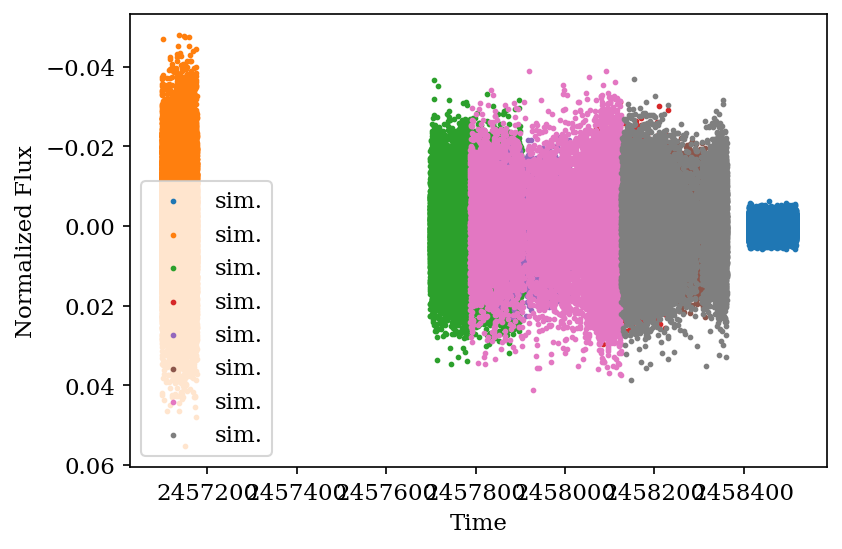

In [534]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(tTESS, model_T[4], s=3, c='C0', label = 'sim.')
ax.scatter(tB15, model_B15[4], s=3, c='C1', label = 'sim.')
ax.scatter(tB16, model_B16[4], s=3, c='C2', label = 'sim.')
ax.scatter(tB17, model_B17[4], s=3, c='C3', label = 'sim.')
ax.scatter(tA17, model_A1[4], s=3, c='C4', label = 'sim.')
ax.scatter(tA18, model_A2[4], s=3, c='C5', label = 'sim.')
ax.scatter(tR1, model_R1[4], s=3, c='C6', label = 'sim.')
ax.scatter(tR2, model_R2[4], s=3, c='C7', label = 'sim.')

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Flux')
ax.legend()
ax.invert_yaxis()

In [540]:
f_TESS = TESS_f + 0.000025

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
44235
1
111813
2
165075
3
229684
[array([2.24382104, 4.55060626, 2.32041317, 3.88595945]), array([1.94392912, 4.07521793, 3.70946085, 1.09761531]), array([6.2344277 , 3.09132826, 4.06779894, 3.99377235]), array([3.25607292, 2.07294887, 5.44484971, 6.07495435])]
[2.24382104 1.94392912 6.2344277  3.25607292]
[4.55060626 4.07521793 3.09132826 2.07294887]
[2.32041317 3.70946085 4.06779894 5.44484971]
[3.88595945 1.09761531 3.99377235 6.07495435]
[[-1.18877794 -1.48866986 -0.33976393 -0.17652605]
 [ 1.11800729  0.64261896 -0.34127071 -1.3596501 ]
 [-1.11218581  0.27686188  0.63519996  2.01225073]
 [ 0.45336047  0.80660899  0.56117338 -0.49923727]]
Calc TD
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


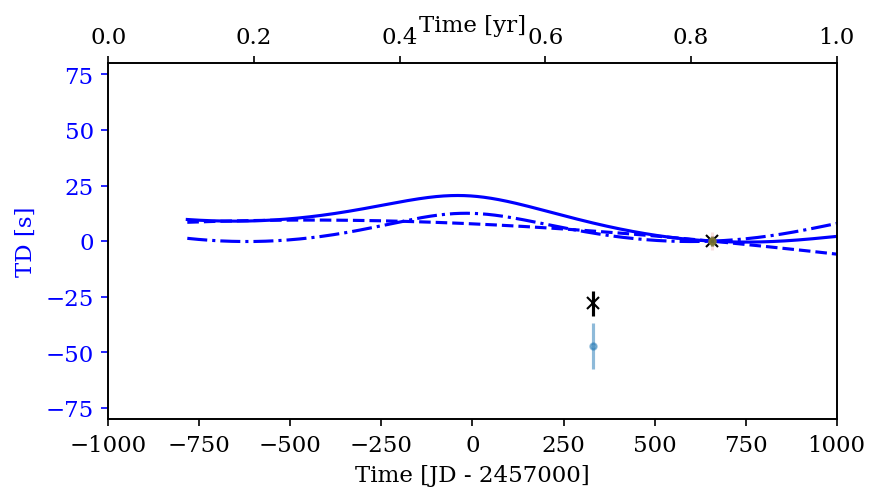

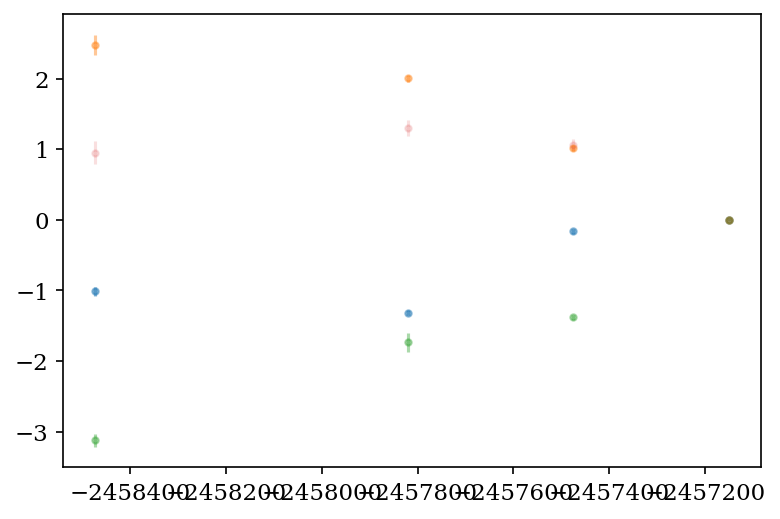

In [541]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


# times_run = tAT
# magnitudes_run = mAT
# segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

times_run = tBT - mid
magnitudes_run = mBT_mod
segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        #print(phase)
        

print(phase)
        
phase = np.array(phase)

ph1 = [phase[iii][0] for iii in range(4)]
ph2 = [phase[iii][1] for iii in range(4)]
ph3 = [phase[iii][2] for iii in range(4)]
ph4 = [phase[iii][3] for iii in range(4)]

ph1 = np.array(ph1)
ph2 = np.array(ph2)
ph3 = np.array(ph3)
ph4 = np.array(ph4)

print(ph1)
print(ph2)
print(ph3)
print(ph4)

# for iii in range(4):
#     ph1 = [phase[iii][0] for iii in range(4)]
#     print(ph1)

mean_phase1 = np.mean(ph1)
mean_phase2 = np.mean(ph2)
mean_phase3 = np.mean(ph3)
mean_phase4 = np.mean(ph4)

ph1[np.where(ph1 - mean_phase1 > np.pi/2)] -= np.pi
ph1[np.where(ph1 - mean_phase1 < -np.pi/2)] += np.pi

ph2[np.where(ph2 - mean_phase2 > np.pi/2)] -= np.pi
ph2[np.where(ph2 - mean_phase2 < -np.pi/2)] += np.pi

ph3[np.where(ph3 - mean_phase3 > np.pi/2)] -= np.pi
ph3[np.where(ph3 - mean_phase3 < -np.pi/2)] += np.pi

ph4[np.where(ph4 - mean_phase4 > np.pi/2)] -= np.pi
ph4[np.where(ph4 - mean_phase4 < -np.pi/2)] += np.pi

phase = [ph1, ph2, ph3, ph4]
phase = np.array(phase)

#phase = np.unwrap(phase)
phase -= np.mean(phase)
#phase = np.array(phase).T
phase_err = np.array(phase_err).T        


print(phase)

#print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    
#     mean_phase = np.mean(ph)
#     ph[np.where(ph - mean_phase > np.pi/2)] -= np.pi
#     ph[np.where(ph - mean_phase < -np.pi/2)] += np.pi
#     ph -= np.mean(ph)
    
    
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = mid

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints), (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints), (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    leg_errbar.append(lns3)
    ax1.set_ylim(-80,80)
    ax1.set_xlim(-1000, 1000)


lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_BT = np.array(time_midpoints)
tau_td_BT = []
for j in range(len(f_TESS)):
    tau_td_BT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][-1]))
tau_td_BT = np.array(tau_td_BT)*86400
tau_err_td_BT = np.array(time_delays_err)*86400
tau_weighted_td_BT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_BT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
21009
1
42020
2
106629
[array([5.90105181, 2.52190919, 3.4210932 , 2.00684823]), array([1.0942657 , 2.26610723, 4.62456226, 0.53449812]), array([3.25607292, 2.07294887, 5.44484971, 6.07495435])]
[5.90105181 1.0942657  3.25607292]
[2.52190919 2.26610723 2.07294887]
[3.4210932  4.62456226 5.44484971]
[2.00684823 0.53449812 6.07495435]
[[-0.50880431  0.96759489 -0.01219055]
 [-0.74635428 -1.00215624 -1.19531459]
 [ 0.15282973  1.35629879  2.17658624]
 [-1.26141523  0.40782731 -0.33490176]]
Calc TD
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


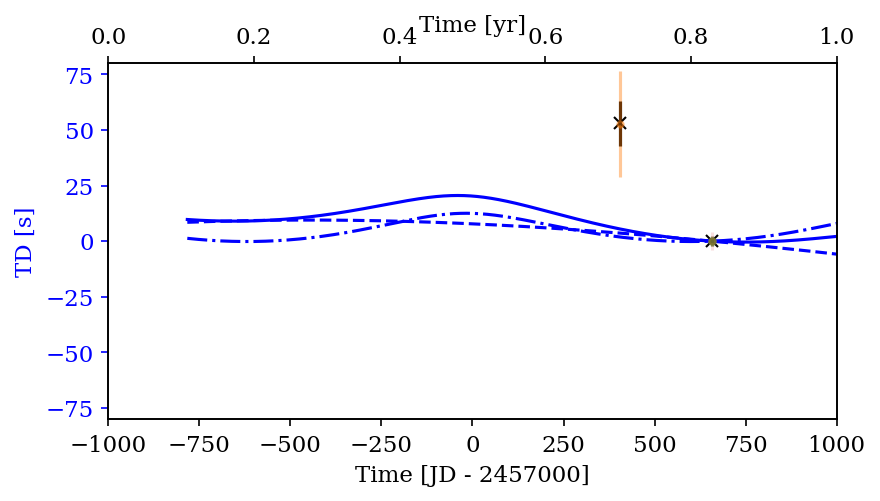

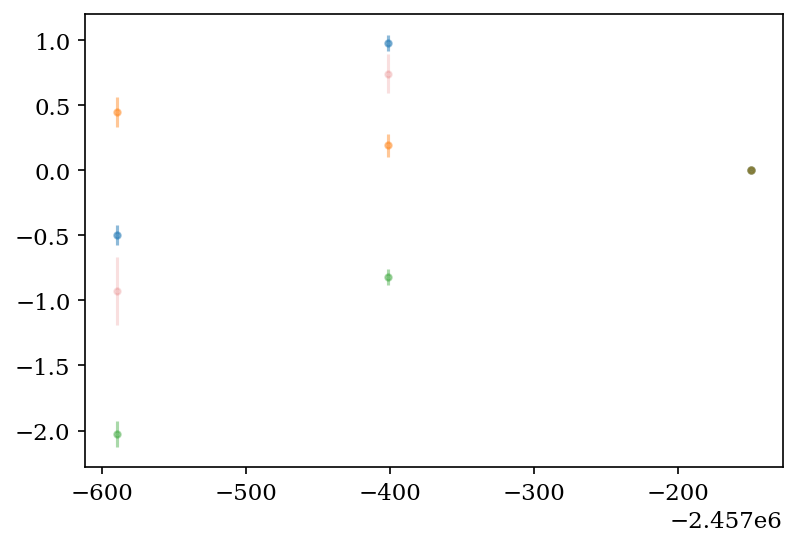

In [542]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


# times_run = tAT
# magnitudes_run = mAT
# segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

times_run = tRT- mid
magnitudes_run = mRT_mod
segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

# times_run = tBT
# magnitudes_run = mBT
# segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        #print(phase)
        

print(phase)
        
phase = np.array(phase)

ph1 = [phase[iii][0] for iii in range(3)]
ph2 = [phase[iii][1] for iii in range(3)]
ph3 = [phase[iii][2] for iii in range(3)]
ph4 = [phase[iii][3] for iii in range(3)]

ph1 = np.array(ph1)
ph2 = np.array(ph2)
ph3 = np.array(ph3)
ph4 = np.array(ph4)

print(ph1)
print(ph2)
print(ph3)
print(ph4)

# for iii in range(4):
#     ph1 = [phase[iii][0] for iii in range(4)]
#     print(ph1)

mean_phase1 = np.mean(ph1)
mean_phase2 = np.mean(ph2)
mean_phase3 = np.mean(ph3)
mean_phase4 = np.mean(ph4)

ph1[np.where(ph1 - mean_phase1 > np.pi/2)] -= np.pi
ph1[np.where(ph1 - mean_phase1 < -np.pi/2)] += np.pi

ph2[np.where(ph2 - mean_phase2 > np.pi/2)] -= np.pi
ph2[np.where(ph2 - mean_phase2 < -np.pi/2)] += np.pi

ph3[np.where(ph3 - mean_phase3 > np.pi/2)] -= np.pi
ph3[np.where(ph3 - mean_phase3 < -np.pi/2)] += np.pi

ph4[np.where(ph4 - mean_phase4 > np.pi/2)] -= np.pi
ph4[np.where(ph4 - mean_phase4 < -np.pi/2)] += np.pi

phase = [ph1, ph2, ph3, ph4]
phase = np.array(phase)

#phase = np.unwrap(phase)
phase -= np.mean(phase)
#phase = np.array(phase).T
phase_err = np.array(phase_err).T        


print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = mid

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints), (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints), (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    leg_errbar.append(lns3)
    ax1.set_ylim(-80,80)
    ax1.set_xlim(-1000, 1000)


lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_RT = np.array(time_midpoints)
tau_td_RT = []
for j in range(len(f_TESS)):
    tau_td_RT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][-1]))
tau_td_RT = np.array(tau_td_RT)*86400
tau_err_td_RT = np.array(time_delays_err)*86400
tau_weighted_td_RT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_RT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
31920
1
64018
2
128627
[array([0.03691621, 3.48340438, 6.25732594, 5.4292483 ]), array([3.06185508, 2.12151656, 1.60573814, 2.71801244]), array([3.25607292, 2.07294887, 5.44484971, 6.07495435])]
[0.03691621 3.06185508 3.25607292]
[3.48340438 2.12151656 2.07294887]
[6.25732594 1.60573814 5.44484971]
[5.4292483  2.71801244 6.07495435]
[[-0.80866015 -0.92531394 -0.7310961 ]
 [-0.50376464 -1.86565246 -1.91422014]
 [-0.87143573  0.76016177  1.45768069]
 [ 1.44207928  1.87243608  2.08778534]]
Calc TD
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


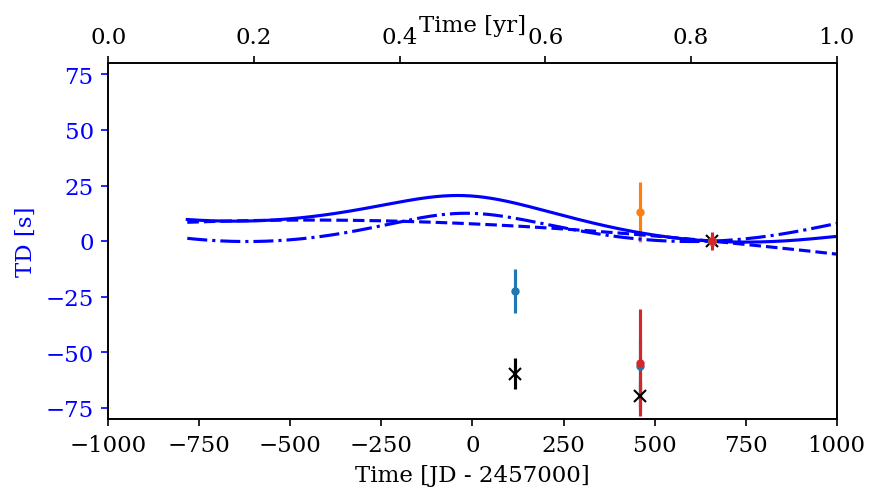

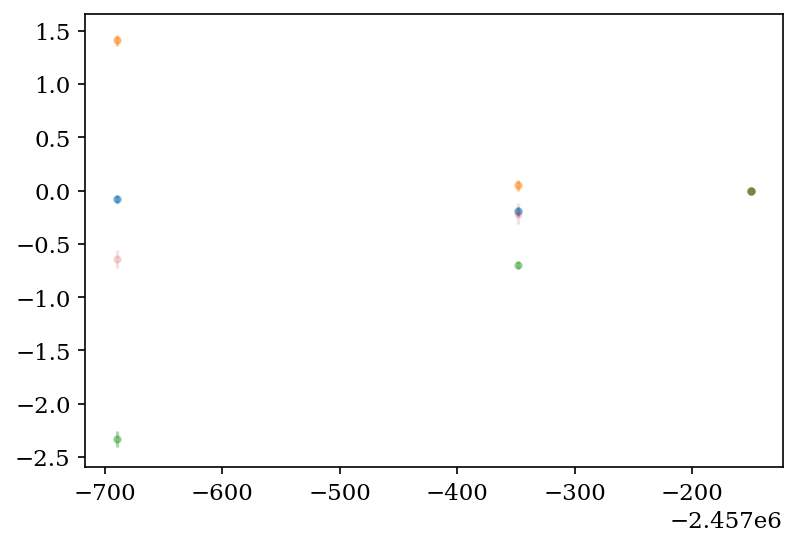

In [543]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


times_run = tAT-mid
magnitudes_run = mAT_mod
segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

# times_run = tBT
# magnitudes_run = mBT
# segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        #print(phase)
        

print(phase)
        
phase = np.array(phase)

ph1 = [phase[iii][0] for iii in range(3)]
ph2 = [phase[iii][1] for iii in range(3)]
ph3 = [phase[iii][2] for iii in range(3)]
ph4 = [phase[iii][3] for iii in range(3)]

ph1 = np.array(ph1)
ph2 = np.array(ph2)
ph3 = np.array(ph3)
ph4 = np.array(ph4)

print(ph1)
print(ph2)
print(ph3)
print(ph4)

# for iii in range(4):
#     ph1 = [phase[iii][0] for iii in range(4)]
#     print(ph1)

mean_phase1 = np.mean(ph1)
mean_phase2 = np.mean(ph2)
mean_phase3 = np.mean(ph3)
mean_phase4 = np.mean(ph4)

ph1[np.where(ph1 - mean_phase1 > np.pi/2)] -= np.pi
ph1[np.where(ph1 - mean_phase1 < -np.pi/2)] += np.pi

ph2[np.where(ph2 - mean_phase2 > np.pi/2)] -= np.pi
ph2[np.where(ph2 - mean_phase2 < -np.pi/2)] += np.pi

ph3[np.where(ph3 - mean_phase3 > np.pi/2)] -= np.pi
ph3[np.where(ph3 - mean_phase3 < -np.pi/2)] += np.pi

ph4[np.where(ph4 - mean_phase4 > np.pi/2)] -= np.pi
ph4[np.where(ph4 - mean_phase4 < -np.pi/2)] += np.pi

phase = [ph1, ph2, ph3, ph4]
phase = np.array(phase)

#phase = np.unwrap(phase)
phase -= np.mean(phase)
#phase = np.array(phase).T
phase_err = np.array(phase_err).T        


print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = mid

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints), (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints), (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.')#, alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    leg_errbar.append(lns3)
    ax1.set_ylim(-80,80)
    ax1.set_xlim(-1000, 1000)



lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_AT = np.array(time_midpoints)
tau_td_AT = []
for j in range(len(f_TESS)):
    tau_td_AT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][-1]))
tau_td_AT = np.array(tau_td_AT)*86400
tau_err_td_AT = np.array(time_delays_err)*86400
tau_weighted_td_AT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_AT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

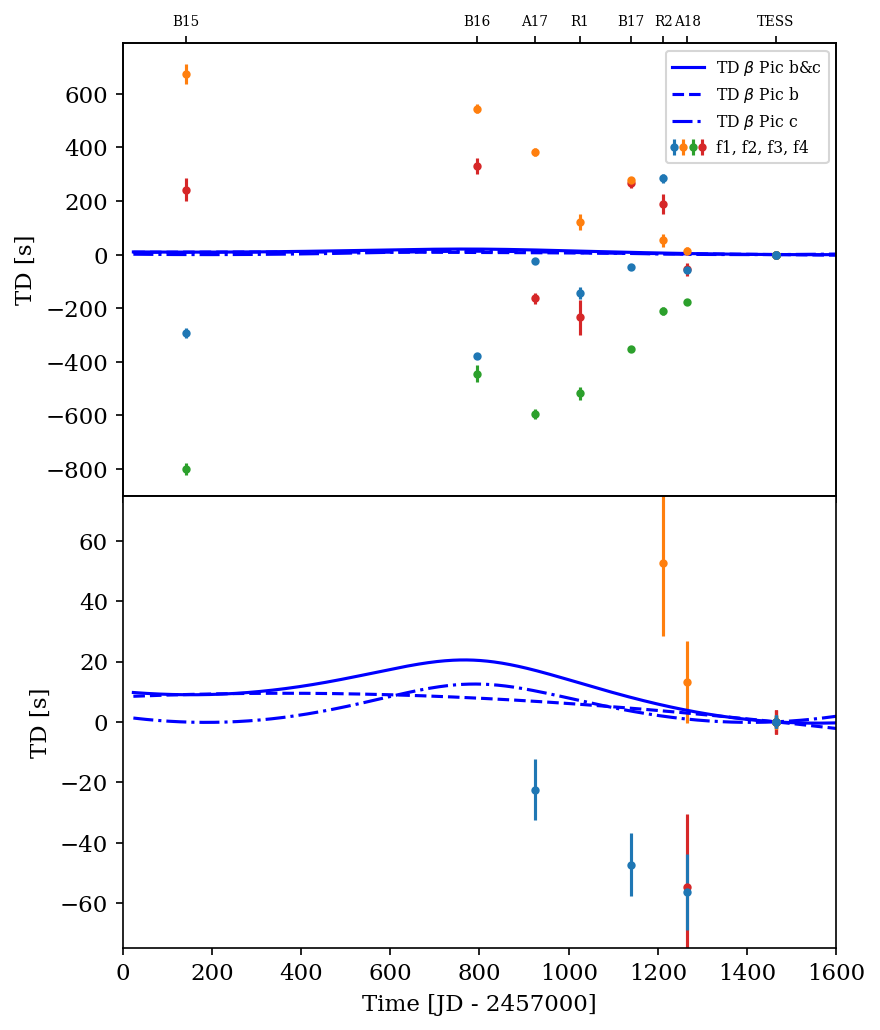

In [545]:
offf = 2457000

fig, ax1 = plt.subplots(2,1, figsize=(6, 7), sharex=True, gridspec_kw={'hspace': 0})

for i in range(4)[::-1]:
    ax1[0].errorbar(t_td_BT+mid-offf, tau_td_BT[i],yerr=tau_err_td_BT[i], c='C{0}'.format(i), fmt='.')
    ax1[0].errorbar(t_td_AT+mid-offf, tau_td_AT[i],yerr=tau_err_td_AT[i], c='C{0}'.format(i), fmt='.')
    ax1[0].errorbar(t_td_RT+mid-offf, tau_td_RT[i],yerr=tau_err_td_RT[i], c='C{0}'.format(i), fmt='.')

ax1[0].plot(times_sim-offf, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
ax1[0].plot(times_sim-offf, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
ax1[0].plot(times_sim-offf, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

ax1[0].set_xlim(jdss[0]-offf-24, jdss[-1]-250-offf)
#ax1[0].set_ylim(-250,550)

ax1[0].legend(prop={'size': 8})



ax1[0].set_xlabel('Time [JD - 2457000]')
ax1[0].set_ylabel('TD [s]')
#ax1.tick_params('y', colors='b')
#ax1.set_ylim(-25,20)


ax2 = ax1[0].twiny()
ax2.tick_params(axis='x', rotation=0)

ax2.set_xticks([np.mean(tB15)-offf,np.mean(tB16)-offf,np.mean(tB17)-offf,np.mean(tA17)-offf,np.mean(tA18)-offf,np.mean(tR1)-offf,np.mean(tR2)-offf,np.mean(tTESS)-offf])

xmin1, xmax1 = ax1[0].get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['B15', 'B16', 'B17', 'A17', 'A18', 'R1', 'R2', 'TESS'], fontsize=6.5)
#ax2.set_xlabel('Time [yr]')
#ax2.xaxis.set_label_coords(0.5,1.125)

# ax3 = ax1.twiny()
# ax3.tick_params(axis='x', rotation=0, pad=5)

# ax3.set_xticks([jdss[0]-offf, jdss[1]-offf, jdss[2]-offf, jdss[3]-offf, jdss[4]-offf])

# ax3.tick_params('both', length=15, width=1, which='major')

# xmin1, xmax1 = ax1.get_xlim()
# ax3.set_xlim(xmin1,xmax1)
# ax3.set_xticklabels(['2015', '2016'], fontsize=6.5)
# ax3.set_xlabel('Time [yr]')
# ax3.xaxis.set_label_coords(0.5,1.2)

#https://stackoverflow.com/questions/52038171/how-to-create-two-legend-objects-for-a-single-plot-instance/52040748#52040748
ax1[0].legend(handles = lns[:3]+[tuple(leg_errbar[:4])], labels=labs[:3]+['f1, f2, f3, f4'],loc=1,prop={'size': 7.5},
              handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})




for i in range(4)[::-1]:
    ax1[1].errorbar(t_td_BT+mid-offf, tau_td_BT[i],yerr=tau_err_td_BT[i], c='C{0}'.format(i), fmt='.')
    ax1[1].errorbar(t_td_AT+mid-offf, tau_td_AT[i],yerr=tau_err_td_AT[i], c='C{0}'.format(i), fmt='.')
    ax1[1].errorbar(t_td_RT+mid-offf, tau_td_RT[i],yerr=tau_err_td_RT[i], c='C{0}'.format(i), fmt='.')

ax1[1].plot(times_sim-offf, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
ax1[1].plot(times_sim-offf, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
ax1[1].plot(times_sim-offf, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

ax1[1].set_xlim(jdss[0]-offf-24, jdss[-1]-250-offf)
ax1[1].set_ylim(-75,75)


ax1[1].set_xlabel('Time [JD - 2457000]')
ax1[1].set_ylabel('TD [s]')

plt.tight_layout()

plt.savefig('final2.png', dpi=500)
plt.savefig('final2.pdf')

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
44235
[4.58474953 0.44451524 0.7659091  2.86974745]
[ 0.11146468  1.09593565  0.83345334 -1.22729756 -0.52506257  1.3744083
 -0.6514342  -1.06996026 -0.15898558  1.19063512  0.13945402 -1.39880815
  0.42026406 -0.39692642  0.92220767  0.51556909 -0.31330519 -0.37365411
  1.19170539  1.29581791  1.3621662   0.87837055  1.40023711  0.82506586
 -1.21001151 -1.39392921 -1.12196831 -0.39874447 -0.64683114 -0.44960417
 -1.22231098 -1.20372793 -0.67254463 -0.23646189 -0.47873082  0.5782926
  0.15270892 -1.41205073]
1
111813
[5.79766109 4.00508159 0.82082667 1.65548101]
[-1.08734717  0.676851    0.74008355 -0.0471066  -0.03477055 -0.81928637
 -1.0119951  -1.23228978  0.57363799 -0.97752208  0.80413253 -0.93938079
 -0.63585292 -0.49121576 -0.88756939 -0.09070082  0.80981503 -0.46847518
  0.18779225 -0.15564483  0.66709835 -0.61901335  0.26162655  0.10798846
 -1.03619338 -0.49898868 -1.17054258 -1.21555552 -1.29571636  1.27811613
 -0.49108197  0.279

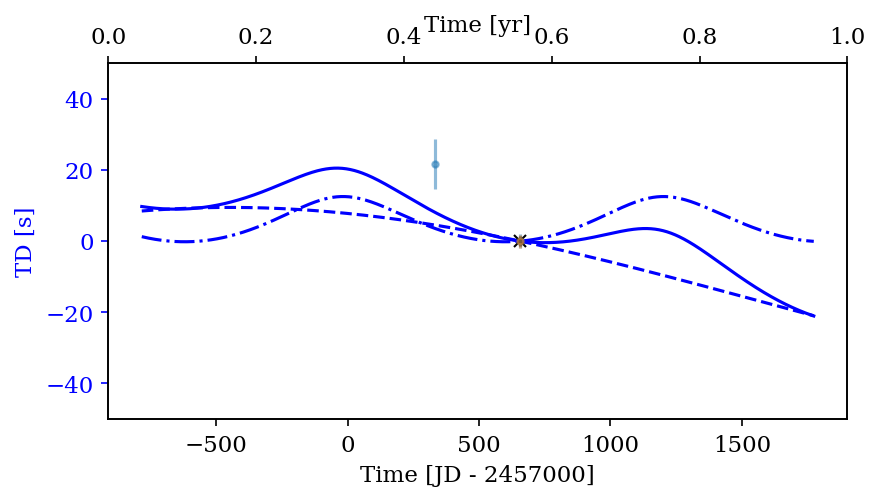

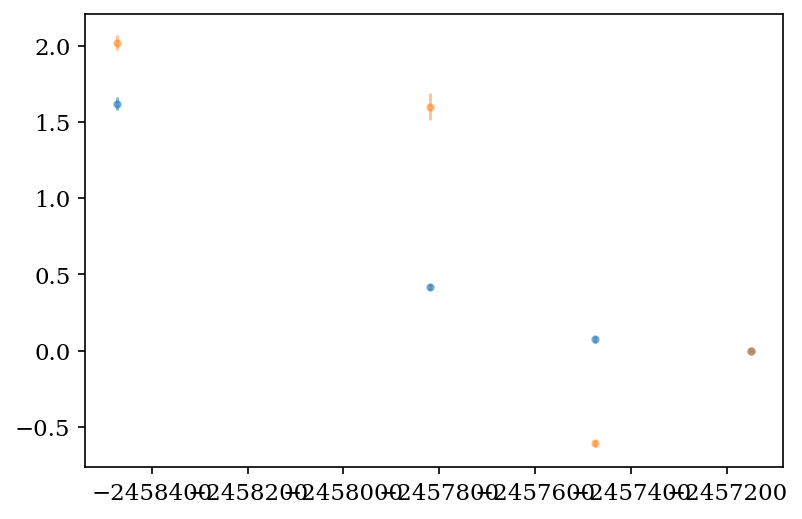

In [450]:
no_freqs_run = 2
no_freqs_run_weighted = 2


print('CALCULATE TIMES')


# times_run = tAT
# magnitudes_run = mAT
# segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

times_run = tBT-mid
magnitudes_run = mBT
segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        print(phase_guess[:4])
        print(get_phase(time_slice, mag_slice, f_TESS))
        
        phase_guess = get_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        #print(phase)
        

phase = np.unwrap(phase)
phase -= np.mean(phase)
phase = np.array(phase).T
phase_err = np.array(phase_err).T

#print(phase)

#print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    
    mean_phase = np.mean(ph)
    ph[np.where(ph - mean_phase > np.pi/2)] -= np.pi
    ph[np.where(ph - mean_phase < -np.pi/2)] += np.pi
    ph -= np.mean(ph)
    
    
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = mid

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints)+mid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints), (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints), (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    leg_errbar.append(lns3)
    ax1.set_ylim(-50, 50)+mid



lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_BT = np.array(time_midpoints)
tau_td_BT = []
for j in range(len(f_TESS)):
    tau_td_BT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][-1]))
tau_td_BT = np.array(tau_td_BT)*86400
tau_err_td_BT = np.array(time_delays_err)*86400
tau_weighted_td_BT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_BT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

In [449]:
phase_guess

array([ 0.11146468,  1.09593565,  0.83345334, -1.22729756])